# Building the prediction model for Random Forest

This is an alternative model being explored where the features are principal components derived from the initial workbook. This will be used to compare performance of the logistic regression model which was developed first for more interpretability

## imports

In [ ]:
# imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

v3 = pd.read_csv('/Users/thomasdoherty/Desktop/football-project/football-project-mvp/prem_v3.csv')

# V3
- Stadium code added
- Manager code
- More of the feature engineered columns to be looked at

In [252]:
v3.sample(3)

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,home_pts_last_5,away_ppg_season,away_pts_last_5,pts_last_5_diff,home_avg_rating,away_avg_rating,best_home_player_rating,best_away_player_rating,home_net_goals,away_net_goals
735,2009-09-26,Fratton Park,7,Portsmouth,Paul Hart,0,1,Everton,David Moyes,-1,...,0,1.50,9,-9,71.0,76.7,80.5,82.5,-0.67,0.27
1409,2012-04-11,Molineux Stadium,33,Wolverhampton Wanderers,Terry Connor,0,3,Arsenal,Arsène Wenger,-1,...,0,1.91,12,-12,63.0,73.4,75.5,85.5,-0.75,0.83
709,2009-08-29,Stamford Bridge,4,Chelsea,Carlo Ancelotti,3,0,Burnley,Owen Coyle,1,...,9,2.00,6,3,84.8,65.9,90.5,72.0,0.98,-0.86


In [253]:
v3.columns

Index(['date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager',
       'Home GF', 'Away GF', 'away_team', 'Away Manager', 'Result', 'Home Win',
       'p(Home)', 'p(Draw)', 'p(Away)', 'Margin', 'id', 'season', 'Home ID',
       'Away ID', 'Venue Code', 'Home Manager Code', 'Away Manager Code',
       'Day', 'Day Code', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'home_avg_rating', 'away_avg_rating',
       'best_home_player_rating', 'best_away_player_rating', 'home_net_goals',
       'away_net_goals'],
      dtype='object')

We can drop the columns below but it may be easier to keep them for when we want to look at which results were predicted right and wrong.

In [110]:
# # Drop Venue, we have Venue Code
# v3.drop('Venue', axis=1, inplace=True)

# # Drop Home Manager and Away Manager, we have Manager Code
# v3.drop(['Home Manager', 'Away Manager'], axis=1, inplace=True)

# # Drop Day, we have day code
# v3.drop('Day', axis=1, inplace=True)

# # Drop Home Team and Away Team, we have team ID
# v3.drop(['home_team', 'away_team'], axis=1, inplace=True)

# # Drop season
# v3.drop('season', axis=1, inplace=True)

# # Drop Margin
# v3.drop('Margin', axis=1, inplace=True)

In [254]:
rf = RandomForestClassifier(
    n_estimators=50, 
    min_samples_split=10, # the number of records before we split a node - e.g. a specific stadium / manager,
    random_state=42)


## Time Series Data

We are training our model on past matches, to be able to predict future ones, so training data should be dated before testing data. If we still aim for around 20-25% testing data then that gives us the last two seasons, which would begin around August 2014. This way:

- Our training data is seasons 2008-09, 09-10, 10-11, 11-12, 12-13, 13-14
- Our testing data is seasons 2014-15 and 2015-16

In [255]:
train = v3[v3['date'] < '2014-08-01']
test = v3[v3['date'] >= '2014-08-01']

In [256]:
test.shape[0] / v3.shape[0]

0.25

## Predictors for V3

In [257]:
v3.columns

Index(['date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager',
       'Home GF', 'Away GF', 'away_team', 'Away Manager', 'Result', 'Home Win',
       'p(Home)', 'p(Draw)', 'p(Away)', 'Margin', 'id', 'season', 'Home ID',
       'Away ID', 'Venue Code', 'Home Manager Code', 'Away Manager Code',
       'Day', 'Day Code', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'home_avg_rating', 'away_avg_rating',
       'best_home_player_rating', 'best_away_player_rating', 'home_net_goals',
       'away_net_goals'],
      dtype='object')

Let's use the venue code and manager codes and the Day codes, in addition to the recent form points in the last 5

Scaling isn't necessary because of the threshold based interpretation of the Random Forest algorithm.

In [258]:
features = ['Venue Code', 'Home ID', 'Away ID', 'Home Manager Code', 'Away Manager Code', 'Day Code', 'home_pts_last_5', 'away_pts_last_5']
target = ['Home Win']

## Training the Model - Predicting a home win or not

In [259]:
rf.fit(v3[features], v3[target])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=42)

### Predictions & Evaluation

In [260]:
preds = rf.predict(test[features])

In [261]:
# Accuracy score
print(accuracy_score(test[target], preds))

# classification report
print(classification_report(test[target], preds))

0.9355263157894737
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       431
           1       0.93      0.92      0.92       329

    accuracy                           0.94       760
   macro avg       0.94      0.93      0.93       760
weighted avg       0.94      0.94      0.94       760



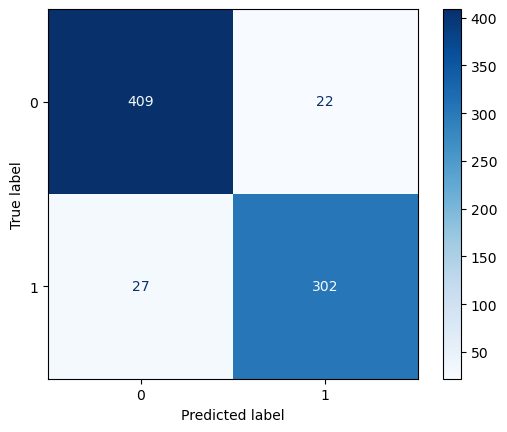

In [262]:
# confusion Matrix
cm = confusion_matrix(test[target], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)


These are amazing results compared to the prior run! The Precision/Recall score is balanced nicely despite a slight class imbalance of more Draws or Away wins than Home wins.

From a percentage standpoint we were stronger at predicting a game would not be a Home win (409/431) than it would (302 / 329) but its both in the low 90% range.

I will try the Win/Draw/Loss now

## Predicting Home Win/ Draw / Away Win

Now predicting a Home, draw or Away win

In [263]:
features = ['Venue Code', 'Home ID', 'Away ID', 'Home Manager Code', 'Away Manager Code', 'Day Code', 'home_pts_last_5', 'away_pts_last_5']
target = ['Result']

In [264]:
rf.fit(v3[features], v3[target])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_split=10, n_estimators=50, random_state=42)

In [265]:
preds_wdl = rf.predict(test[features])

### Home/Draw/Away - Model Evaluation

In [266]:
# Accuracy score
print(accuracy_score(test[target], preds_wdl))

# classification report
print(classification_report(test[target], preds_wdl))

0.8828947368421053
              precision    recall  f1-score   support

          -1       0.94      0.83      0.88       231
           0       0.98      0.78      0.87       200
           1       0.82      0.99      0.89       329

    accuracy                           0.88       760
   macro avg       0.91      0.86      0.88       760
weighted avg       0.90      0.88      0.88       760



You can even see in the testing portion here the breakdown of result frequencies

-1 (Away win) was 231 / 760 = 30.4%
0 (Draw) was 200 / 760 = 26.3%
1 (Home win) was 329 / 43.2%

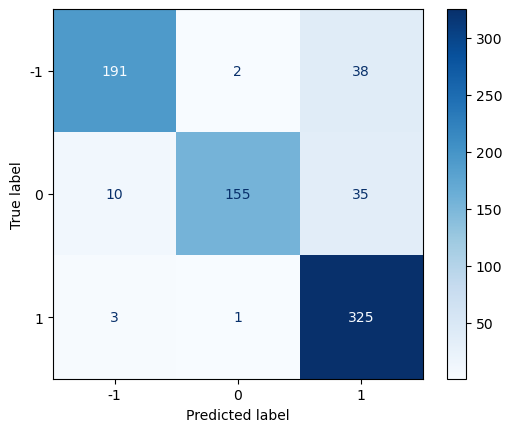

In [267]:
# confusion matrix 
cm = confusion_matrix(test[target], preds_wdl)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)

These are incredible results compared to the 52% I was finding before in V2. 

I do not know exactly what prompted the huge uptick. Whether the time series fix for the training/testing dataset helped, or the venue codes (recognizing the importance of some teams' home performance) balanced with recent form and a particular manager gave enough rules for a RF classifier to break through.

We still see a slight tendency towards predicting home wins rather than draws or losses as we saw in V1 and 2.

In [268]:
# feature importance

importances = rf.feature_importances_
feature_names = v3[features].columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(importance_df.sort_values(by='Importance', ascending=False))

             Feature  Importance
4  Away Manager Code    0.156711
2            Away ID    0.148117
3  Home Manager Code    0.133166
7    away_pts_last_5    0.129518
6    home_pts_last_5    0.128328
1            Home ID    0.123545
0         Venue Code    0.113222
5           Day Code    0.067394


We can see the Away Manager is seemingly more important than the home manager! Perhaps this is how the home field advantage is nullified, some managers (and teams, closely behind) are capable of overcoming it.

#### Example Tree Paths
- it's still a black box but you can see the main conditions around recent form and some Manager IDs

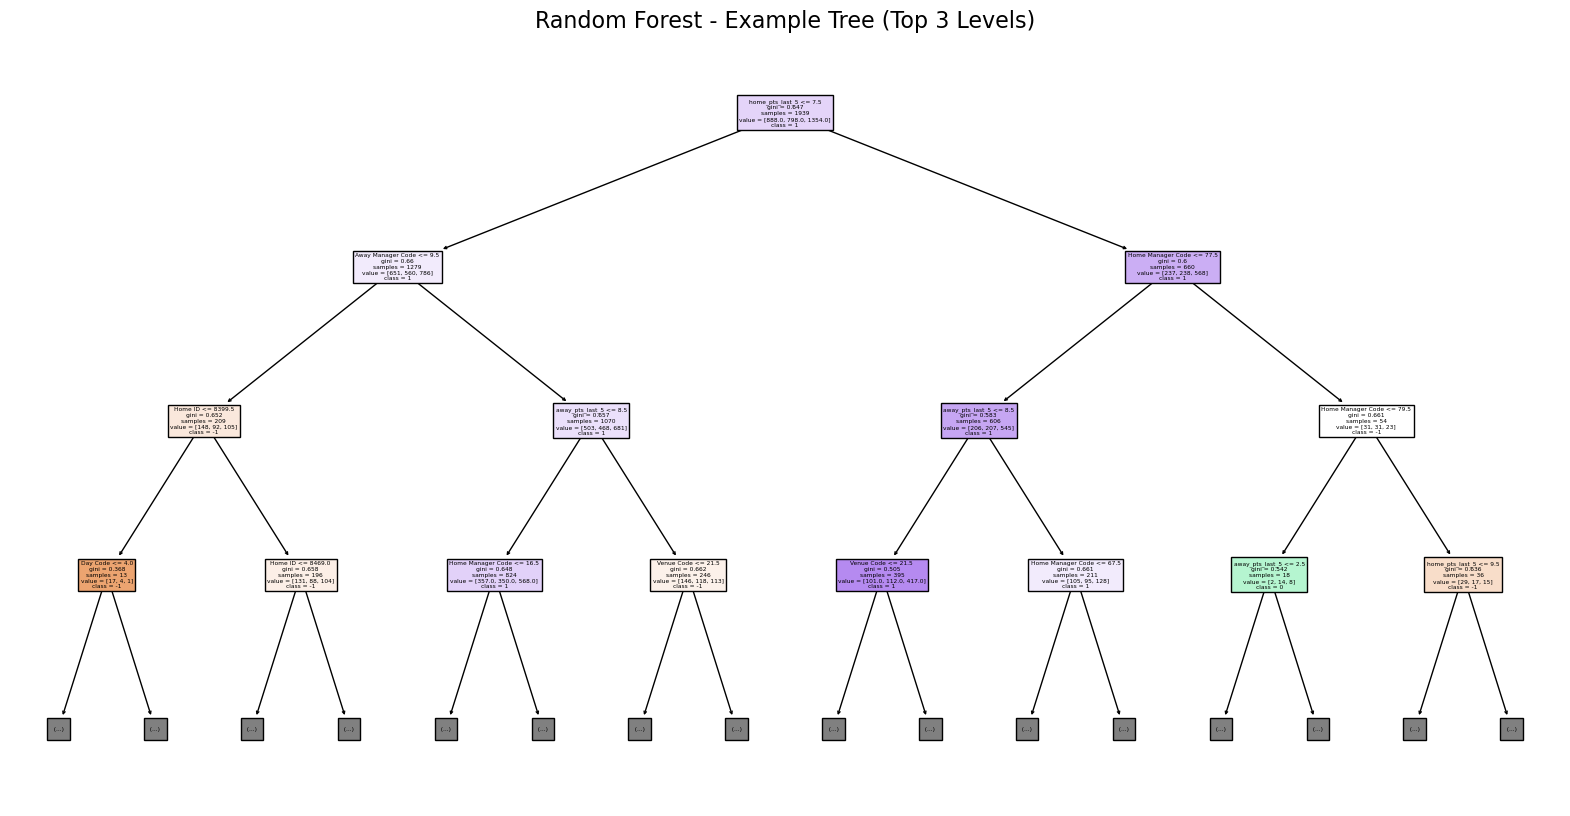

In [271]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize one tree with a limited depth
plt.figure(figsize=(20, 10))
plot_tree(
    rf.estimators_[0],  # Select one tree from the Random Forest
    feature_names=features,  # Replace with your feature names
    class_names=['-1', '0', '1'],  # Replace with your class names
    filled=True,
    max_depth=3  # Display only the top 3 levels
)
plt.title("Random Forest - Example Tree (Top 3 Levels)", fontsize=16)
plt.show()

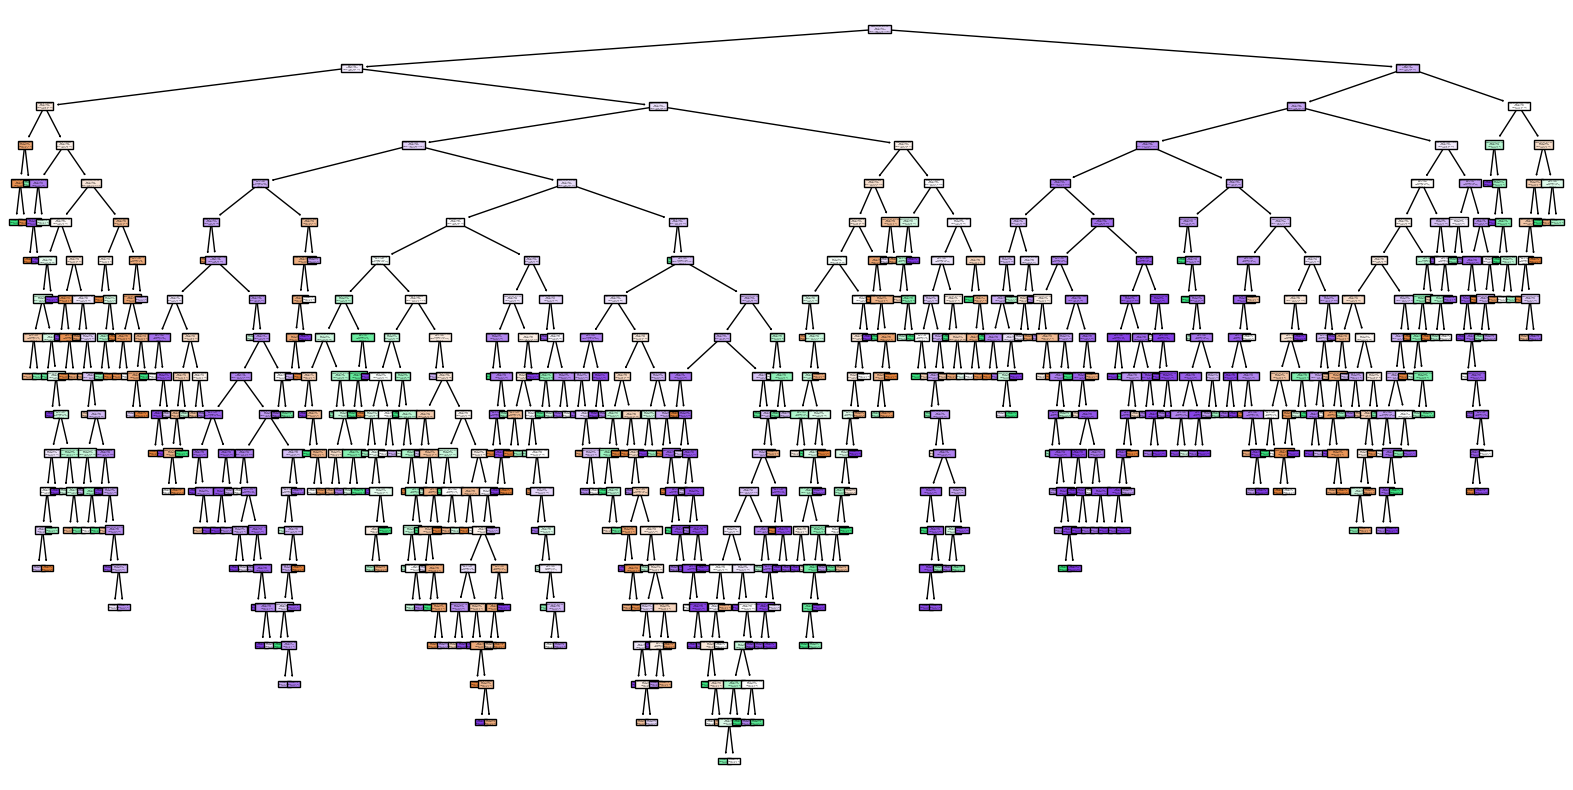

In [269]:
from sklearn.tree import plot_tree

# Visualize one tree in the forest
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=features, class_names=['-1', '0', '1'], filled=True)
plt.show()

### Combine predictions with the test set

In [232]:
test.index

Index([2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289,
       ...
       3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039],
      dtype='int64', length=760)

In [233]:
v3.index

RangeIndex(start=0, stop=3040, step=1)

In [ ]:
# Ensure target column is 1-dimensional
actual_results = test[target].squeeze()  # Converts (760, 1) to (760,) if needed

# Create a DataFrame for predictions and actual results
results_df = pd.DataFrame({
    'Actual Result': actual_results,  # Ensure this is 1D
    'Predicted Result': preds_wdl.squeeze()  # Ensure predictions are 1D
}, index=test.index)  # Retain the same index as the test set

# Extract human-readable columns using test.index from v3
original_columns = ['date', 'Venue', 'home_team', 'Home GF', 'Away GF', 'away_team', 'Home Manager', 'Away Manager', 'home_pts_last_5', 'away_pts_last_5', 'Day']
readable_columns = v3.loc[test.index, original_columns]

# Combine readable columns and prediction results
results_with_details = pd.concat([results_df, readable_columns], axis=1)

# Display the results DataFrame
results_with_details

,Actual Result,Predicted Result,date,Venue,home_team,Home GF,Away GF,away_team,Home Manager,Away Manager,home_pts_last_5,away_pts_last_5,Day
2280,1,1,2014-08-16,Emirates Stadium,Arsenal,2,1,Crystal Palace,Arsène Wenger,Tony Pulis,0,0,Saturday
2281,-1,-1,2014-08-18,Turf Moor,Burnley,1,3,Chelsea,Sean Dyche,José Mourinho,0,0,Monday
2282,0,0,2014-08-16,King Power Stadium,Leicester City,2,2,Everton,Nigel Pearson,Roberto Martínez,0,0,Saturday
2283,1,1,2014-08-17,Anfield,Liverpool,2,1,Southampton,Brendan Rodgers,Ronald Koeman,0,0,Sunday
2284,-1,1,2014-08-16,Old Trafford,Manchester United,1,2,Swansea City,Louis van Gaal,Garry Monk,0,0,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3035,0,0,2015-10-17,St Mary's Stadium,Southampton,2,2,Leicester City,Ronald Koeman,Claudio Ranieri,10,8,Saturday
3036,-1,-1,2015-10-19,Swansea.com Stadium,Swansea City,0,1,Stoke City,Garry Monk,Mark Hughes,5,7,Monday
3037,0,0,2015-10-17,White Hart Lane,Tottenham Hotspur,0,0,Liverpool,Mauricio Pochettino,Jürgen Klopp,11,5,Saturday
3038,-1,-1,2015-10-17,Vicarage Road,Watford,0,3,Arsenal,Quique Sánchez Flores,Arsène Wenger,7,12,Saturday


### Results we missed

- Which results did we mis-predict?

In [ ]:
# saving to csv
results_with_details.to_csv('/Users/thomasdoherty/Desktop/football-project/football-project-mvp/v3_results_details.csv', index=False)

In [244]:
# which results were predicted incorrectly
incorrect = results_with_details[results_with_details['Actual Result'] != results_with_details['Predicted Result']]

print(incorrect.shape)

incorrect.sample(50)

(89, 13)


,Actual Result,Predicted Result,date,Venue,home_team,Home GF,Away GF,away_team,Home Manager,Away Manager,home_pts_last_5,away_pts_last_5,Day
2436,-1,1,2015-02-01,St Mary's Stadium,Southampton,0,1,Swansea City,Ronald Koeman,Garry Monk,13,5,Sunday
2795,0,1,2016-01-13,Etihad Stadium,Manchester City,0,0,Everton,Manuel Pellegrini,Roberto Martínez,10,5,Wednesday
2458,-1,1,2015-02-11,bet365 Stadium,Stoke City,1,4,Manchester City,Mark Hughes,Manuel Pellegrini,8,6,Wednesday
2538,-1,1,2015-04-11,The Hawthorns,West Bromwich Albion,2,3,Leicester City,Tony Pulis,Nigel Pearson,6,4,Saturday
2595,0,-1,2015-05-24,MKM Stadium,Hull City,0,0,Manchester United,Steve Bruce,Louis van Gaal,6,4,Sunday
2680,-1,1,2015-10-31,Stamford Bridge,Chelsea,1,3,Liverpool,José Mourinho,Jürgen Klopp,7,7,Saturday
2799,-1,1,2016-01-13,White Hart Lane,Tottenham Hotspur,0,1,Leicester City,Mauricio Pochettino,Claudio Ranieri,10,8,Wednesday
2739,0,1,2015-12-12,Upton Park,West Ham United,0,0,Stoke City,Slaven Bilić,Mark Hughes,3,10,Saturday
2572,0,1,2015-05-10,Stamford Bridge,Chelsea,1,1,Liverpool,José Mourinho,Brendan Rodgers,13,7,Sunday
2568,-1,1,2015-05-03,White Hart Lane,Tottenham Hotspur,0,1,Manchester City,Mauricio Pochettino,Manuel Pellegrini,8,9,Sunday


### Results we missed

Which results did we get wrong here? From the confusion matrix, it would be likely misclassifying other away wins or draws as Home wins

Looking at the above, these are reasonable results to get wrong in the circumstances. Spot checking a few:
- **Stoke City 2 - 1 West Ham, 2015-05-15**, the model predicted a West Ham win. 
    - West Ham were in much better form going in (8 pts last 5 vs 1 for Stoke, terrible form), and although not in the dataframe, West Ham had European qualification in sight, which Stoke did not. It was a dead rubber for Stoke, with nothing to play for in the last game of the season.
    - We could with the points tallied, add a feature for league position and make some connection to whether a team can still win the league / get relegated / qualify for Europe. This was a classic game of one team that had something to play for whilst the others did not, and an anomalous result in the circumstances.

- **Manchester City 1 - 2 West Ham, 2015-09-19**, the model predicted a City win.
    - Manchester City had won all 5 previous games (15 pts last 5) and West Ham, whilst in good form, were not expected to win this game. However, they had recently already beaten Arsenal and Liverpool away from home this season so far, arguably the two most challenging venues to win as a visiting team, and got a third unlikely away win in this game and (as of December 2024) have not won at Etihad Stadium since. This was, in all honesty as a West Ham fan, an anomalous result.

- **Manchester City 1 - 4 Liverpool 2015-11-21**, The model predicted a City win. 
    - City were in better form going into the contest and it is very rare for City to be beaten at home. Although Liverpool are an elite team, it takes a large number of factors to bet on Manchester City losing at home. 

- **Manchester City 0 - 1 Stoke City, 2014-08-30** - Model predicted a City win.
    - Again City losing at home is extremely rare, to a mid table team especially. This was an early game of the season (perhaps GW 3 or 4) so the form is not yet established.

#### Were some stadiums / venues harder to predict the match than others?

In [238]:
# for the test data get a value count of every venue and the number of games played there
test['Venue'].value_counts()

Venue
Emirates Stadium       38
Villa Park             38
White Hart Lane        38
Swansea.com Stadium    38
Stadium of Light       38
St Mary's Stadium      38
Etihad Stadium         38
Goodison Park          38
Selhurst Park          38
Stamford Bridge        38
Upton Park             38
The Hawthorns          38
bet365 Stadium         38
St James' Park         38
Old Trafford           38
Anfield                38
King Power Stadium     38
Turf Moor              19
MKM Stadium            19
Loftus Road            19
Vitality Stadium       19
Carrow Road            19
Vicarage Road          19
Name: count, dtype: int64

In [246]:
print(incorrect['Venue'].value_counts())

Venue
White Hart Lane       10
Stamford Bridge       10
Anfield                9
Etihad Stadium         8
Emirates Stadium       7
Goodison Park          7
The Hawthorns          6
Old Trafford           5
Stadium of Light       4
MKM Stadium            3
St Mary's Stadium      3
King Power Stadium     3
Upton Park             3
Selhurst Park          3
bet365 Stadium         2
Villa Park             1
Loftus Road            1
Turf Moor              1
Vitality Stadium       1
Vicarage Road          1
Carrow Road            1
Name: count, dtype: int64


In [250]:
# Count incorrect predictions by venue
incorrect_predictions = incorrect['Venue'].value_counts()

# Count total matches by venue
total_matches = test['Venue'].value_counts()

# Combine using merge to align correctly
venue_stats = pd.merge(
    total_matches.rename('Total Matches'), 
    incorrect_predictions.rename('Incorrect Predictions'), 
    left_index=True, 
    right_index=True, 
    how='left'
).fillna(0)  # Fill NaN values with 0 for venues without incorrect predictions

# Convert to integers for clarity
venue_stats['Incorrect Predictions'] = venue_stats['Incorrect Predictions'].astype(int)
venue_stats['Total Matches'] = venue_stats['Total Matches'].astype(int)

# Calculate Incorrect %
venue_stats['Incorrect %'] = round((venue_stats['Incorrect Predictions'] / venue_stats['Total Matches']) * 100, 1)

# Reset the index for better readability
venue_stats.reset_index(inplace=True)
venue_stats.rename(columns={'index': 'Venue'}, inplace=True)

# Display the DataFrame
venue_stats


,Venue,Total Matches,Incorrect Predictions,Incorrect %
0,Emirates Stadium,38,7,18.4
1,Villa Park,38,1,2.6
2,White Hart Lane,38,10,26.3
3,Swansea.com Stadium,38,0,0.0
4,Stadium of Light,38,4,10.5
5,St Mary's Stadium,38,3,7.9
6,Etihad Stadium,38,8,21.1
7,Goodison Park,38,7,18.4
8,Selhurst Park,38,3,7.9
9,Stamford Bridge,38,10,26.3


In [245]:
print(sum(venue_stats['Incorrect Predictions']), 'of', sum(venue_stats['Total Matches']), 'predictions were incorrect')

89 of 760 predictions were incorrect


In [197]:
# and which ones we got right?
correct = results_with_details[results_with_details['Actual Result'] == results_with_details['Predicted Result']]

correct

,Actual Result,Predicted Result,date,Venue,home_team,Home GF,Away GF,away_team,Home Manager,Away Manager,Day
2280,1,1,2014-08-16,Emirates Stadium,Arsenal,2,1,Crystal Palace,Arsène Wenger,Tony Pulis,Saturday
2281,-1,-1,2014-08-18,Turf Moor,Burnley,1,3,Chelsea,Sean Dyche,José Mourinho,Monday
2282,0,0,2014-08-16,King Power Stadium,Leicester City,2,2,Everton,Nigel Pearson,Roberto Martínez,Saturday
2283,1,1,2014-08-17,Anfield,Liverpool,2,1,Southampton,Brendan Rodgers,Ronald Koeman,Sunday
2285,-1,-1,2014-08-17,St James' Park,Newcastle United,0,2,Manchester City,Alan Pardew,Manuel Pellegrini,Sunday
...,...,...,...,...,...,...,...,...,...,...,...
3035,0,0,2015-10-17,St Mary's Stadium,Southampton,2,2,Leicester City,Ronald Koeman,Claudio Ranieri,Saturday
3036,-1,-1,2015-10-19,Swansea.com Stadium,Swansea City,0,1,Stoke City,Garry Monk,Mark Hughes,Monday
3037,0,0,2015-10-17,White Hart Lane,Tottenham Hotspur,0,0,Liverpool,Mauricio Pochettino,Jürgen Klopp,Saturday
3038,-1,-1,2015-10-17,Vicarage Road,Watford,0,3,Arsenal,Quique Sánchez Flores,Arsène Wenger,Saturday


## V2

In [ ]:
df.sample(5)

,PC1,PC2,PC3,PC4,p(Home),p(Draw),p(Away),Result
2964,0.005641,-0.282010,-1.129980,0.930118,0.457,0.258,0.285,1
1895,-0.403886,0.500769,-0.961058,-0.194123,0.457,0.258,0.285,1
2657,-0.857472,-0.891843,-0.075507,0.028527,0.457,0.258,0.285,-1
1584,-2.036530,0.256216,-0.330386,-0.645570,0.457,0.258,0.285,1
1453,-2.132244,1.370095,-1.306988,1.773362,0.457,0.258,0.285,1


### Train the model

In [ ]:
# Step 1: Split data into features (X) and target (y)
X_pca = df.drop('Result', axis=1)
y_pca = df['Result']

In [ ]:
# Step 2: Train-test split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

In [ ]:
# Step 3: Train Random Forest Classifier
rf_model = RandomForestClassifier(
    random_state=42, 
    n_estimators=100,  # Number of trees
    max_depth=5,       # Limit depth of each tree (same as decision tree for comparability)
    n_jobs=-1          # Use all available CPU cores for training
)
rf_model.fit(X_train_pca, y_train_pca)

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42)

In [ ]:
# Step 4: Evaluate the Random Forest Model
y_pred_pca_rf = rf_model.predict(X_test_pca)

In [ ]:
# Accuracy and classification report
print("PCA Run Random Forest:")
print("Accuracy:", accuracy_score(y_test_pca, y_pred_pca_rf))
print(classification_report(y_test_pca, y_pred_pca_rf))

PCA Run Random Forest:
Accuracy: 0.5164473684210527
              precision    recall  f1-score   support

          -1       0.49      0.49      0.49       177
           0       0.60      0.02      0.04       152
           1       0.53      0.80      0.64       279

    accuracy                           0.52       608
   macro avg       0.54      0.44      0.39       608
weighted avg       0.53      0.52      0.44       608



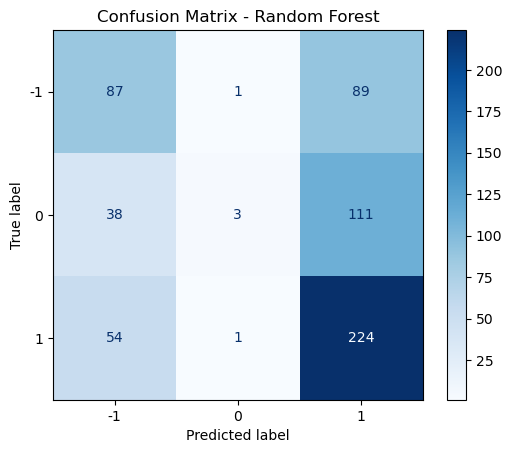

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_pca, y_pred_pca_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [ ]:
# print the cm
print(cm_pca_tree)

[[194   9  76]
 [ 79   5  68]
 [ 69   1 107]]


## Initial analysis

V2

__________


V1

With chance being 0.33, the initial performance of 50.33% is slightly worse than the logistic regression but its performance differs in that:
- It is slightly stronger in predicting away wins
- It is slightly weaker in predicting home wins
- It is willing to bet on draws occurring

The recall scores being higher than the precision scores shows that we will get a lot of false positives for the home win or away win.

However...**it is struggling with draws**

### V2 Feature importance


In [ ]:
importances = rf_model.feature_importances_
feature_names = X_pca.columns
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")

PC1: 0.1748
PC2: 0.5453
PC3: 0.1287
PC4: 0.1511
p(Home): 0.0000
p(Draw): 0.0000
p(Away): 0.0000


PC2 is clearly the most important feature contributing to predictions here, From the loadings in the previous workbook, this is the PC most related to differences between the home and away team.

PC1 has a lot of variance too and it is the next most important feature but less than 1/3 as important as PC2.